In [1]:
!pip install -U pip
!pip install accelerate==0.18.0
!pip install appdirs==1.4.4
!pip install bitsandbytes==0.37.2
!pip install datasets==2.10.1
!pip install fire==0.5.0
!pip install git+https://github.com/huggingface/peft.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install torch==2.0.0
!pip install sentencepiece==0.1.97
!pip install tensorboardX==2.6
!pip install gradio==3.23.0

  Using cached accelerate-0.18.0-py3-none-any.whl (215 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.25.0
    Uninstalling accelerate-0.25.0:
      Successfully uninstalled accelerate-0.25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.7.2.dev0 requires accelerate>=0.21.0, but you have accelerate 0.18.0 which is incompatible.
  Cloning https://github.com/huggingface/peft.git to /tmp/pip-req-build-09fzlf7h
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /tmp/pip-req-build-09fzlf7h
  Resolved https://github.com/huggingface/peft.git to commit cf04d0353f0343cbf66627228c4495f51669af34
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached accelerate-0.25.0-py3-none-any.whl.metad

In [2]:
import transformers
import textwrap
from transformers import LlamaTokenizer, LlamaForCausalLM
import os
import sys
from typing import List

from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
)

import fire
import torch
from datasets import load_dataset
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams

%matplotlib inline
sns.set(rc={'figure.figsize':(10, 7)})
sns.set(rc={'figure.dpi':100})
sns.set(style='white', palette='muted', font_scale=1.2)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
!gdown 1xQ89cpZCnafsW5T3G3ZQWvR7q682t2BN

Downloading...
From: https://drive.google.com/uc?id=1xQ89cpZCnafsW5T3G3ZQWvR7q682t2BN
To: /content/bitcoin-sentiment-tweets.csv
100% 242k/242k [00:00<00:00, 113MB/s]


In [4]:
df = pd.read_csv("bitcoin-sentiment-tweets.csv")
df.head()

,date,tweet,sentiment
0,Fri Mar 23 00:40:40 +0000 2018,@p0nd3ea Bitcoin wasn't built to live on excha...,1.0
1,Fri Mar 23 00:40:40 +0000 2018,@historyinflicks Buddy if I had whatever serie...,1.0
2,Fri Mar 23 00:40:42 +0000 2018,@eatBCH @Bitcoin @signalapp @myWickr @Samsung ...,0.0
3,Fri Mar 23 00:41:04 +0000 2018,@aantonop Even if Bitcoin crash tomorrow morni...,0.0
4,Fri Mar 23 00:41:07 +0000 2018,I am experimenting whether I can live only wit...,1.0


In [5]:
df.sentiment.value_counts()

 0.0    860
 1.0    779
-1.0    258
Name: sentiment, dtype: int64

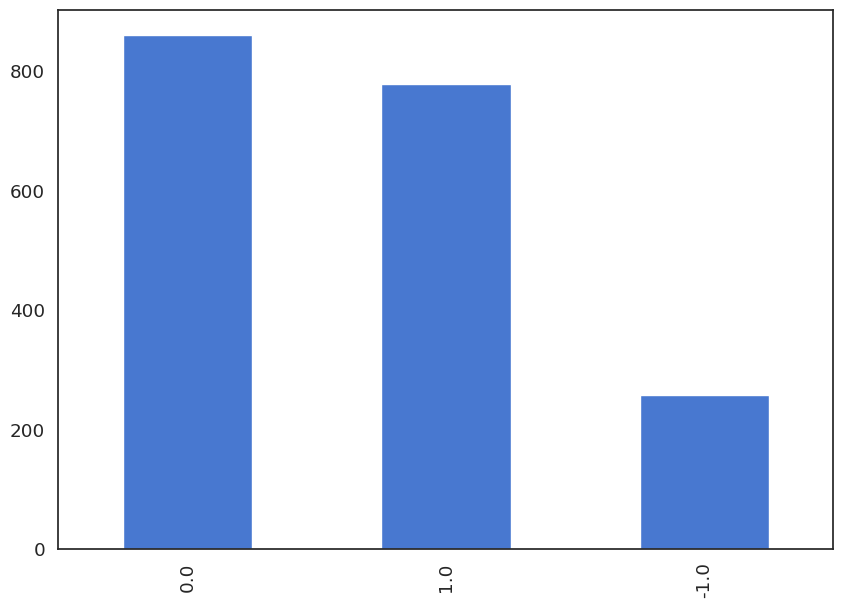

In [6]:
df.sentiment.value_counts().plot(kind='bar');

# **```📊 Build JSON Dataset```**

In [7]:
def sentiment_score_to_name(score: float):
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    return "Neutral"

dataset_data = [
    {
        "instruction": "Detect the sentiment of the tweet.",
        "input": row_dict["tweet"],
        "output": sentiment_score_to_name(row_dict["sentiment"])
    }
    for row_dict in df.to_dict(orient="records")
]

dataset_data[0]

{'instruction': 'Detect the sentiment of the tweet.',
 'input': "@p0nd3ea Bitcoin wasn't built to live on exchanges.",
 'output': 'Positive'}

In [8]:
import json
with open("alpaca-bitcoin-sentiment-dataset.json", "w") as f:
  json.dump(dataset_data, f)

# **```📊 Model Weights```**

In [ ]:
from transformers import LlamaForCausalLM, LlamaTokenizer
import torch

BASE_MODEL = "NousResearch/llama-2-7b-chat-hf"

# Specify the device_map
device_map = {"cuda:0": "cpu"}  # You may need to adjust the device according to your setup

# Load the model using standard methods
model = LlamaForCausalLM.from_pretrained(BASE_MODEL)

# Set the appropriate options
model.load_in_8bit = True
model.to(torch.float16)
model.to("cpu")  # Move the model to the CPU

tokenizer = LlamaTokenizer.from_pretrained(BASE_MODEL)

tokenizer.pad_token_id = 0  # unk. we want this to be different from the eos token
tokenizer.padding_side = "left"


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# **```📊 Dataset```**

In [ ]:
data = load_dataset("json", data_files="alpaca-bitcoin-sentiment-dataset.json")
data["train"]

In [ ]:
def generate_prompt(data_point):
    return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.  # noqa: E501
### Instruction:
{data_point["instruction"]}
### Input:
{data_point["input"]}
### Response:
{data_point["output"]}"""


def tokenize(prompt, add_eos_token=True):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=CUTOFF_LEN,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < CUTOFF_LEN
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    result["labels"] = result["input_ids"].copy()

    return result

def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenize(full_prompt)
    return tokenized_full_prompt

In [ ]:
train_val = data["train"].train_test_split(
    test_size=200, shuffle=True, seed=42
)
train_data = (
    train_val["train"].map(generate_and_tokenize_prompt)
)
val_data = (
    train_val["test"].map(generate_and_tokenize_prompt)
)

# **```📊 Training```**

In [ ]:
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT= 0.05
LORA_TARGET_MODULES = [
    "q_proj",
    "v_proj",
]

BATCH_SIZE = 128
MICRO_BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE
LEARNING_RATE = 3e-4
TRAIN_STEPS = 300
OUTPUT_DIR = "experiments"

In [ ]:
model = prepare_model_for_int8_training(model)
config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)
model.print_trainable_parameters()

In [ ]:
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=100,
    max_steps=TRAIN_STEPS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_steps=10,
    optim="adamw_torch",
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    save_steps=50,
    output_dir=OUTPUT_DIR,
    save_total_limit=3,
    load_best_model_at_end=True,
    report_to="tensorboard"
)

In [ ]:
data_collator = transformers.DataCollatorForSeq2Seq(
    tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
)

In [ ]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=training_arguments,
    data_collator=data_collator
)
model.config.use_cache = False
old_state_dict = model.state_dict
model.state_dict = (
    lambda self, *_, **__: get_peft_model_state_dict(
        self, old_state_dict()
    )
).__get__(model, type(model))

model = torch.compile(model)

trainer.train()
model.save_pretrained(OUTPUT_DIR)

# **```📊 Push To HuggingFace```**

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

model.push_to_hub("curiousily/alpaca-bitcoin-tweets-sentiment", use_auth_token=True)

# **```📊 Inference```**

In [1]:
!git clone https://github.com/tloen/alpaca-lora.git
%cd alpaca-lora
!git checkout a48d947

Cloning into 'alpaca-lora'...
remote: Enumerating objects: 607, done.
remote: Total 607 (delta 0), reused 0 (delta 0), pack-reused 607
Receiving objects: 100% (607/607), 27.84 MiB | 11.90 MiB/s, done.
Resolving deltas: 100% (358/358), done.
/content/alpaca-lora
Note: switching to 'a48d947'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at a48d947 把中文LoRA放在一起


In [ ]:
!python generate.py \
    --load_8bit \
    --base_model 'decapoda-research/llama-7b-hf' \
    --lora_weights 'curiousily/alpaca-bitcoin-tweets-sentiment' \
    --share_gradio